## eXterme Gradient Boosting (XGBoost) 

### Omar Abukassab
### Maseeh Department of Civil, Architectural, and Environmental Engineering, The University of Texas at Austin

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences

_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Elnara Rustamzade, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/elnara-rustamzade/)


### Executive Summary

This project focuses on investigating the performance of XGBoost in classifying high and low production rate classes for both balanced and imbalanced datasets. XGBoost was applied and optimized through hyperparameter tuning, and its performance was assessed using various evaluation metrics.

* XGBoost demonstrated strong performance across evaluation metrics on the balanced and the imbalanced datasets.

* A larger dataset enables a more robust evaluation of XGBoost’s performance.



### XGBoost vs Gradient Boosting
eXtreme Gradient Boosting (XGBoost) is a highly efficient and scalable machine learning algorithm based on the gradient boosting framework. It was developed to push the limits of computational speed and model performance. XGBoost builds an ensemble of decision trees, where each new tree attempts to correct the errors made by the previous ones, similar to traditional gradient boosting.

XGBoost is considered superior to traditional gradient boosting. The table below highlights the advantages of XGBoost over traditional gradient boosting:
| Feature                   | Gradient Boosting                                       | XGBoost (Extreme Gradient Boosting)                     |
|:------------------------:|:-------------------------------------------------------:|:--------------------------------------------------------:|
| **Core Idea**            | Sequentially reduces errors using weak learners         | Optimized gradient boosting with system enhancements     |
| **Speed**                | Slower, no parallelization                              | Much faster, supports parallel computing                 |
| **Regularization**       | Not included by default                                 | Includes L1 and L2 regularization                        |
| **Missing Values Handling** | Requires data preprocessing                          | Automatically handled during training                    |
| **Overfitting Control**  | Basic (e.g., early stopping)                            | Advanced (regularization, shrinkage, subsampling)        |


### XGBoost for classification 


### 1. Import packages

Import the necessary packages to apply and evaluate the XGBoost model.

### 2. Functions

Define the functions required for hyperparameter optimization and plotting.

### 3. Build XGBoost model for balanced and imbalanced dataset

Steps to build and evaluate the model:

1- Prepare training and testing datasets.

2- Perform grid search for hyperparameter tuning.

3- Train the model and generate predictions.

4- Evaluate the model using evaluation metrics such as recall, precision, and F1_score.
* For the balanced dataset, use Shapley values to identify the most influential features.
* Compare model performance on balanced and imbalanced datasets.


### About Me

I am Omar Abukassab, a MS/PhD student in Geotechnical Enginnering at UT-Austin.

My specialty is Geotechnical Earthquake Engineering, with a focus on seismic landslides assessment.

[LinkedIn](https://www.linkedin.com/in/omar-abukassab-658a75241?lipi=urn%3Ali%3Apage%3Ad_flagship3_profile_view_base_contact_details%3BWz8BcGViS4m%2FaSCA8oxlPg%3D%3D)


# 1. Import Packages


In [ ]:
import numpy as np                                        # for working with data and model arrays
import pandas as pd                                       # for working with tabular data
from xgboost import XGBClassifier                         # XGBClassifier used for binary classification
from sklearn.model_selection import GridSearchCV          # hyperparameter tuning using grid search
from sklearn.metrics import cohen_kappa_score,make_scorer # score required to apply grid search
from sklearn.metrics import confusion_matrix              # confusion matrix to generate FP,TP,TN,FN
import seaborn as sns                                     # plotting 
import matplotlib.pyplot as plt                           # plotting
import shap                                               # Shapley to investigate most contributing features
from sklearn.metrics import f1_score                      # calculates f1_score


# 2. Functions

The following functions will be used in the workflow.

In [83]:
def xgb_grid_search(X, y,no_pos,no_neg): # Grid search for imbalanced data
    weight=(no_neg-no_pos)/no_pos
    weight=np.where(weight==0,1,weight)# calculate the weight to scale the positive class
    model = XGBClassifier()
    kappa = make_scorer(cohen_kappa_score)
    param_grid = {
        'max_depth': (range(1,8)),
        'n_estimators': (50,100,200,250),
        'learning_rate': (0.05, 0.10, 0.20),
        'subsample': (0.4,0.6,0.8,1),
        'scale_pos_weight': [weight]                    # the model will be penalized for the error made in the positive class

    }

    grid = GridSearchCV(model, param_grid, cv=2, scoring=kappa, verbose=True)
    grid.fit(X, y)

    print("Best Parameters:", grid.best_params_)

In [ ]:
def splitting_datasets(df,x,y,z,seed):                     #x is points sampled from positive class,y is points sampled from negative class
    df['Prod_class']=np.where(df['Prod']>z,1,0)       #transform production data, values higher than the median is 1, and lower than the median is 0
    df_testing_1=df[df['Prod_class']==1].sample(x,random_state=seed)
    df_testing_0=df[df['Prod_class']==0].sample(y,random_state=seed)
    testing_dataset=pd.concat([df_testing_1,df_testing_0])
    testing_predictor_features=testing_dataset[['Por','Perm','AI','Brittle','TOC','VR']]  #testing predictor features
    testing_response_features=testing_dataset['Prod_class']  #testing response feature
    df=df.drop(df_testing_1.index)  # Drop the sampled testing data points from the original dataset. The remaining points are the training dataset
    df=df.drop(df_testing_0.index)
    training_predictor_features=df[['Por','Perm','AI','Brittle','TOC','VR']]   #testing predictor features
    training_response_features=df['Prod_class'] #testing response feature
    return testing_predictor_features,testing_response_features,training_predictor_features,training_response_features


In [87]:
def plotting_confusion_matrix(x,y):                 # plotting_confusion_matrix
    testing_predicitions=xgb.predict(x)             # generate predictions
    cm = confusion_matrix(y, testing_predicitions)  # calculate confusion matrix
    tn, fp, fn, tp=cm.ravel()
    print('True negatives =',tn)
    print('True positives =',tp)
    print('False negatives =',fn)
    print('False positives =',fp)
    labels = ['Negative', 'Positive']
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels,annot_kws={"size": 12})
    plt.xlabel('Predicted',fontsize=12)
    plt.ylabel('Actual',fontsize=12)
    plt.title('Confusion Matrix Heatmap',fontsize=14)
    plt.xticks(fontsize=11) 
    plt.yticks(fontsize=11) 
    plt.tight_layout()
    plt.show()
    return tn, fp, fn, tp

In [89]:
def plotting_evaluation_metrics(tp,fn,fp):            # plotting_evaluation_metrics
    Recall = tp/(tp+fn)
    Precision = tp/(tp+fp)
    F1_score=2/((1/Recall)+(1/Precision))
    fid,ax=plt.subplots()
    bars=ax.bar([1,2,3],[Recall,Precision,F1_score],color=['blue','orange','green'])
    ax.bar_label(bars, fmt='%.2f', padding=3)
    ax.set_xticks([1,2,3])
    ax.set_xticklabels(['Recall','Precision','F1_score'])
    # plt.legend()
    ax.set_ylim(0,1.1)
    ax.set_title("Model Performance Metrics")
    ax.set_ylabel("Score")
    ax.grid(axis='y')
    plt.show()


In [91]:
def Model_perfromance_comparison (R_B,P_B,F_B,R_IMB,P_IMB,F_IMB):
    fid,ax=plt.subplots()
    fid.set_size_inches((6,5))
    w=0.2
    x=[1,2,3]
    bars1=ax.bar([i -w/2 for i in x],[R_B,P_B,F_B],width=w,color='red',label='Balanced dataset')
    bars2=ax.bar([i +w/2 for i in x],[R_IMB,P_IMB,F_IMB],width=w,color='black',label='Imbalanced dataset')
    ax.bar_label(bars1,fmt='%.2f',padding=3)
    ax.bar_label(bars2,fmt='%.2f',padding=3)
    ax.set_xticks([1,2,3])
    ax.set_xticklabels(['Recall','Precision','F1_score'],fontsize=12)
    ax.set_ylim(0,1.2)
    ax.set_yticks(np.arange(0,1.2,0.2))
    ax.set_title("Model Performance Comparison")
    ax.set_ylabel("Score",fontsize=12)
    plt.legend()
    ax.grid(axis='y')
    plt.tight_layout()
    plt.show()


In [93]:
def plotting_class_distribution(x,y):                          # plotting_class_distribution
    train_counts = x.value_counts().sort_index()
    test_counts = y.value_counts().sort_index()
    categories = [0, 1]
    train_vals = [train_counts.get(i, 0) for i in categories]
    test_vals = [test_counts.get(i, 0) for i in categories]
    bar_width = 0.5
    bar_labels = ['Class 0', 'Class 1']
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.bar('Train', train_vals[0], label='Class 0', color='skyblue')
    ax.bar('Train', train_vals[1], bottom=train_vals[0], label='Class 1', color='steelblue')
    ax.bar('Test', test_vals[0], color='skyblue')
    ax.bar('Test', test_vals[1], bottom=test_vals[0], color='steelblue')
    ax.set_ylabel("Number of Samples")
    ax.set_title("Class Distribution in Train and Test Sets")
    ax.set_ylim(0,200)
    ax.set_yticks(range(0,225,25))
    ax.legend(title="Prod_class")
    plt.tight_layout()
    plt.show()

### Load Data

The following workflow applies the .csv file 'unconv_MV_v5.csv'. The dataset is publicly available in Prof. Michael Pyrcz [here](https://github.com/GeostatsGuy/GeoDataSets)  

We will work with the following features:

* **Porosity** - fraction of rock void (%)
* **Permeability** - ability of a fluid to flow through the rock in milliDarcy
* **Acoustic impedence** - product of sonic velocity and rock density in units of $kg/m^2s*10^3$
* **Brittleness** - rock's tendency to fracture or break (%)
* **Total Organic Carbon** - crucial geochemical parameter to evaluate source rock potential (%)
* **Vitrinite reflectance** - thermal maturity indicator to assess if a source rock has reached the temperature necessary to generate oil (%)


In [96]:
# load the comma delimited data file from Dr. Pyrcz's GeoDataSets GitHub repository
df = pd.read_csv(r"https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/unconv_MV_v5.csv")

* Drop 'Well' column. The remaining columns represent the six predictor variables and the response variable (Production)

In [99]:
df=df.drop(df.columns[0],axis=1)
df.describe()

,Por,Perm,AI,Brittle,TOC,VR,Prod
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,14.991150,4.330750,2.968850,48.161950,0.990450,1.964300,4311.219852
std,2.971176,1.731014,0.566885,14.129455,0.481588,0.300827,992.038414
min,6.550000,1.130000,1.280000,10.940000,-0.190000,0.930000,2107.139414
25%,12.912500,3.122500,2.547500,37.755000,0.617500,1.770000,3618.064513
50%,15.070000,4.035000,2.955000,49.510000,1.030000,1.960000,4284.687348
75%,17.402500,5.287500,3.345000,58.262500,1.350000,2.142500,5086.089761
max,23.550000,9.870000,4.630000,84.330000,2.180000,2.870000,6662.622385


# 3.1 Build XBGoost model for balanced dataset

### 3.1.1 Prepare training and testing datasets

Production rate is a continuous variable. To transform it into a binary variable (0 or 1), we need to define a threshold—where 0 represents low production and 1 represents high production.

The choice of threshold plays a key role in determining class imbalance. To create a balanced dataset, we initially use the median of the production rate as the threshold. To obtain a balanced dataset, we use the median of production rate, this splits the data into 100 high production and 100 low production data points.



In [ ]:
testing_predictor_features,testing_response_features,training_predictor_features,training_response_features=splitting_datasets(df,20,20,df['Prod'].median(),42)

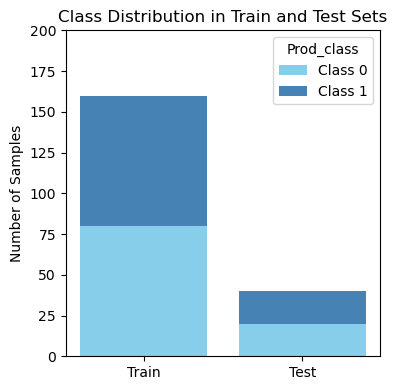

In [ ]:
plotting_class_distribution(training_response_features,testing_response_features)

Class distribution figure shows balanced training and testing data. The first step to build the model is complete.

### 3.1.2 Grid search for hyperparameters tuning

In [ ]:
no_pos=len(training_response_features[training_response_features==1])   # number of positive and negative points to calculate scale_pos_weight
no_neg=len(training_response_features[training_response_features==0])
grid_result=xgb_grid_search(training_predictor_features, training_response_features,no_pos,no_neg)

Fitting 2 folds for each of 336 candidates, totalling 672 fits


We tuned the hyperparameters required to control the complexity of the model. Since we obtained our balanced dataset and tuned the hyperparameters. we are ready to apply the model.

### 3.1.3 Apply the model and generate predictions

In [109]:
xgb=XGBClassifier(max_depth=4,learning_rate=0.05,n_estimators=50,subsample=0.8,scale_pos_weight=1)
xgb.fit(training_predictor_features, training_response_features)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)

We fitted the XGBoost model. To evaluate its performance we calculate evaluation metrics such as: precision, recall, and F1_score.

### 3.1.4 Model Evaluation

The formulas for the evaluation metrics — recall, precision, and F1_score — are presented as follows
(equations from [Dr.Pyrcz ebook](https://geostatsguy.github.io/MachineLearningDemos_Book/MachineLearning_naive_Bayes.html))

$$
Precision_k = \frac{ n_{k,\text{true  positives}} }{ n_{k,\text{true  positives}} + n_{k,\text{false  positives}}} = \frac{ n_{k,\text{true  positives}} }{ n_{k, \text{all  positives}} }
$$

$$
Recall_k = \frac{ n_{k, \text{true  positives}} }{n_{k,\text{true  positives}} + n_{k,\text{false  negatives}}}
$$

$$
f1-score_k = \frac{2} { \frac{1}{Precision_k} + \frac{1}{Recall_k} }
$$


As shown in the equations above, we need to obtain true positives (TP), true negatives (TN), false negatives (FN), and false positives (FP) by calculating the confusion matrix

True negatives = 18
True positives = 20
False negatives = 0
False positives = 2


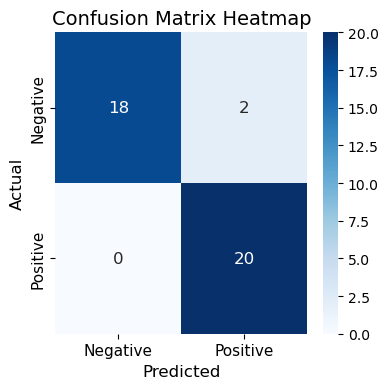

In [114]:
# code to plot the confusion matrix from Dr.Pyrcz ebook https://geostatsguy.github.io/MachineLearningDemos_Book/MachineLearning_naive_Bayes.html
tn, fp, fn, tp=plotting_confusion_matrix(testing_predictor_features,testing_response_features)

After obtaining the confusion matrix, we apply the equations to calculate each evaluation metric.

In [117]:
Recall_balanced_dataset = tp/(tp+fn)
Precision_balanced_dataset = tp/(tp+fp)
F1_score_balanced_dataset=2/((1/Recall_balanced_dataset)+(1/Precision_balanced_dataset))

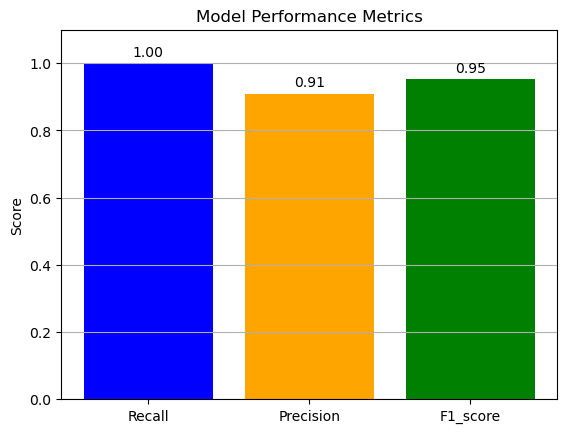

In [119]:
plotting_evaluation_metrics(tp,fn,fp)

### Shapley values for balanced dataset

Shapley values are used to identify the key features influencing model's predictions. They also reveal which specific feature values push the model toward predicting either the positive or negative class.

In [123]:
explainer=shap.TreeExplainer(xgb)                   # Calculate Shapley Values
shap_values_testing=explainer(testing_predictor_features)

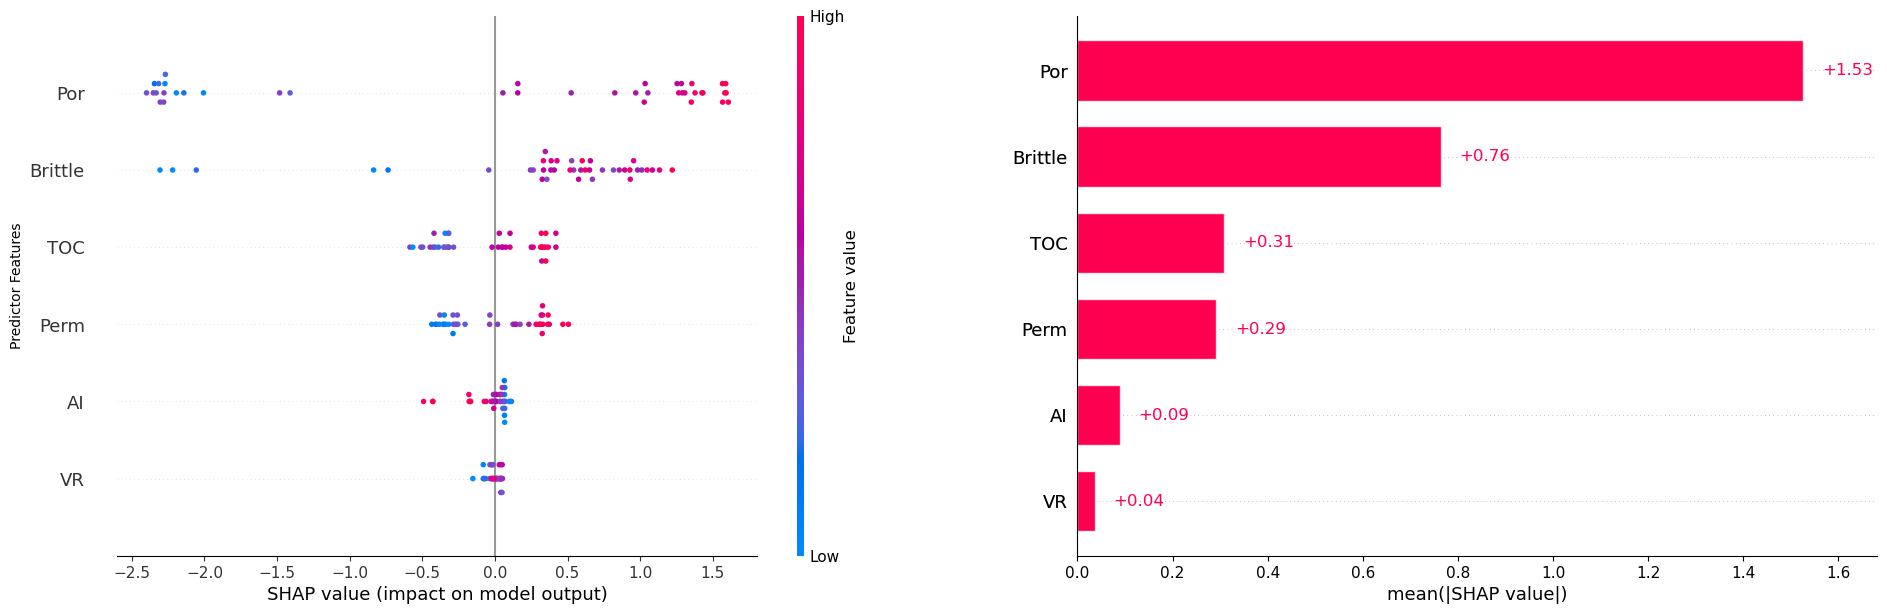

In [125]:
plt.subplot(121)       # code from Dr. Pyrcz ebook https://geostatsguy.github.io/MachineLearningDemos_Book/MachineLearning_feature_ranking.html
shap.plots.beeswarm(shap_values_testing,max_display = 27,show=False)
plt.ylabel('Predictor Features')

plt.subplot(122)
shap.plots.bar(shap_values_testing,max_display = 27,show=False)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()


The plot on the right shows the Shapley values for each feature across the entire testing dataset, while the plot on the left is a bar chart of the mean absolute Shapley values. The Shapley values indicate that the most contributing features are Porosity and Brittleness.

The results of applying XGBoost to the balanced dataset yielded high values for recall, precision, and F1_score. Now, let's investigate the model's performance on the unbalanced dataset.


# 3.2 Build XBGoost model for imbalanced dataset
We split the training and testing datasets in an imbalanced manner by using a higher production threshold (5,000), resulting in more low production data points. To ensure consistency in evaluating XGBoost's performance on both balanced and imbalanced datasets, we hold out 20 high production and 20 low production data points as the testing set.

We follow the same steps for building the XGBoost model as we did in **section 3.1**


### 3.2.1 Prepare training and testing datasets


In [130]:
testing_predictor_features,testing_response_features,training_predictor_features,training_response_features=splitting_datasets(df,20,20,5000,42)
testing_predictor_features.head()

,Por,Perm,AI,Brittle,TOC,VR
75,18.73,7.46,2.88,53.39,1.42,2.14
160,16.21,4.01,2.77,59.83,1.21,2.32
192,20.37,6.69,2.37,37.76,1.40,1.99
50,18.72,5.75,2.57,44.74,1.59,1.96
166,19.06,9.49,3.20,55.53,1.57,2.39


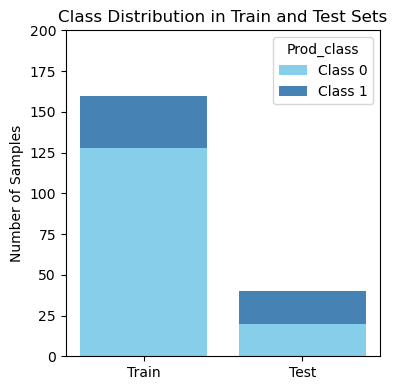

In [132]:
plotting_class_distribution(training_response_features,testing_response_features)

The training dataset is imbalanced now. Number of negative class points is higher.

### 3.2.2 Grid search for hyperparameters tuning

In [ ]:
no_pos=len(training_response_features[training_response_features==1])   # number of positive and negative points to calculate scale_pos_weight
no_neg=len(training_response_features[training_response_features==0])
grid_result=xgb_grid_search(training_predictor_features, training_response_features,no_pos,no_neg)

Fitting 2 folds for each of 336 candidates, totalling 672 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 50, 'scale_pos_weight': array(3.), 'subsample': 0.8}


Grid search is applied to tune hyperparameters. Notice that scale_pos_weight value is now = 3 because we need to penalize the model for errors made in predicting the minor (positive) class.

### 3.2.3 Apply the model and generate predictions

In [136]:
xgb=XGBClassifier(max_depth=2,learning_rate=0.2,n_estimators=50,subsample=0.8,scale_pos_weight=3)
xgb.fit(training_predictor_features, training_response_features)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)

### 3.2.4 Model Evaluation


True negatives = 20
True positives = 15
False negatives = 5
False positives = 0


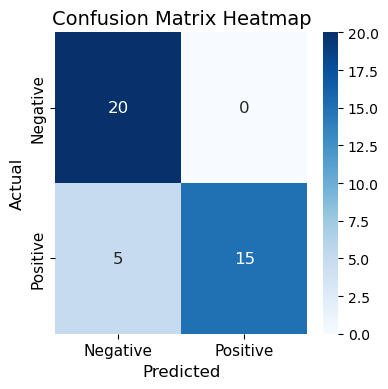

In [139]:
tn, fp, fn, tp=plotting_confusion_matrix(testing_predictor_features,testing_response_features)

We notice that the model the model missed 5 actual positive (fn) points, but was able to capture all negative instances. Let's compare how the model performed on the imbalanced dataset by visualizing evaluation metrics results in a one summary plot of results for both balanced and imbalanced datasets. This will give more insight about model behavior.

### Model performance comaprison on balanced and imbalanced datasets

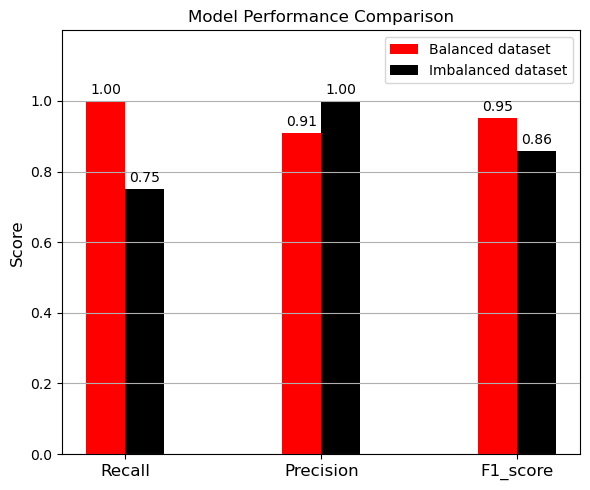

In [143]:
Recall_imbalanced_dataset = tp/(tp+fn)
Precision_imbalanced_dataset = tp/(tp+fp)
F1_score_imbalanced_dataset=2/((1/Recall_imbalanced_dataset)+(1/Precision_imbalanced_dataset))
Model_perfromance_comparison(Recall_balanced_dataset,Precision_balanced_dataset,F1_score_balanced_dataset,Recall_imbalanced_dataset,Precision_imbalanced_dataset,F1_score_imbalanced_dataset)

* The model performance comparison shows how data imbalance affects XGBoost. Although the precision was higher by 9% than the balanced data, the recall decreased by 25%
* The model excelled in predicting the dominant negative class.
* Evaluation of the model in such case depends also on what evaluation metrics are considered to evaluate the model performance
* The size of dataset is small, perhaps if we have a larger dataset we can include more positive class point for the model to learn from, even if the data is imbalanced

The comparison performed was for one trial of splitting the dataset. This does not tell you how stable or robust the model is. To effectively evaluate the model performance, we randomize train-test split with different seeds and calculate the evaluation metrics for balanced and imbalanced dataset for each seed. The appropriate evaluation metric to calculate is the F1_score since it penalizes imbalance between precision and recall by leaning toward the lower metric. 

Upon calculating F1_score for each seed, we can visualize its distribution for balanced and imbalanced dataset to assess model performance. We assume the hyperparameters do not change with each seed. For more accurate results of splitting the dataset, we can apply Grid search for each seed but it will be time expensive to apply grid search for each seed.

In [147]:
F1_balanced=[]                                 # calculating F_1 score for balanced and imbalanced dataset
F1_imbalanced=[]
for seed in range(50):                         # use 50 seeds to evaluate to calculate the distribution
    #Balanced_dataset 
    testing_predictor_features,testing_response_features,training_predictor_features,training_response_features=splitting_datasets(df,20,20,df['Prod'].median(),seed)
    model_b=XGBClassifier(max_depth=4,learning_rate=0.05,n_estimators=50,subsample=0.8,scale_pos_weight=1)
    model_b.fit(training_predictor_features, training_response_features)
    y_pred_b=model_b.predict(testing_predictor_features)
    F1_balanced.append(f1_score(testing_response_features,y_pred_b))
    
    #Imbalanced_dataset 
    testing_predictor_features,testing_response_features,training_predictor_features,training_response_features=splitting_datasets(df,20,20,5000,seed)
    model_i=XGBClassifier(max_depth=2,learning_rate=0.2,n_estimators=50,subsample=0.8,scale_pos_weight=3)
    model_i.fit(training_predictor_features, training_response_features)
    y_pred_i=model_i.predict(testing_predictor_features)
    F1_imbalanced.append(f1_score(testing_response_features,y_pred_i))

We calculated F1_score over 50 a range of seeds for the balanced and imbalanced datasets. Now let's visualize the distribution

C:\Users\oakas\AppData\Local\Temp\ipykernel_18516\1191876575.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=f1_df, x="Type", y='F1 Score', palette=['blue', 'orange'],width=0.2,inner='quart',fill=False)


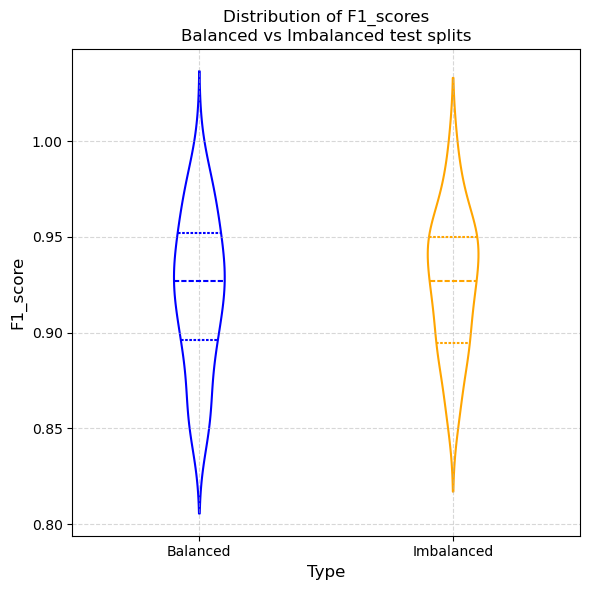

In [149]:
f1_df = pd.DataFrame({'F1 Score': F1_balanced + F1_imbalanced,
'Type': ['Balanced'] * len(F1_balanced) + ['Imbalanced'] * len(F1_imbalanced)})
plt.figure(figsize=(6, 6))
sns.violinplot(data=f1_df, x="Type", y='F1 Score', palette=['blue', 'orange'],width=0.2,inner='quart',fill=False)
plt.title("Distribution of F1_scores\nBalanced vs Imbalanced test splits")
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel('Type',fontsize=12)
plt.ylabel('F1_score',fontsize=12)
plt.tight_layout()
plt.show()

* The similarity in F1-score distributions between balanced and imbalanced datasets indicates that the model maintains good and consistent performance regardless of class distribution, suggesting strong robustness to imbalance.

#### About the Supervising Professor

Michael Pyrcz is a professor in the [Cockrell School of Engineering](https://cockrell.utexas.edu/faculty-directory/alphabetical/p), and the [Jackson School of Geosciences](https://www.jsg.utexas.edu/researcher/michael_pyrcz/), at [The University of Texas at Austin](https://www.utexas.edu/), where he researches and teaches subsurface, spatial data analytics, geostatistics, and machine learning. Michael is also,

* the principal investigator of the [Energy Analytics](https://fri.cns.utexas.edu/energy-analytics) freshmen research initiative and a core faculty in the Machine Learn Laboratory in the College of Natural Sciences, The University of Texas at Austin

* an associate editor for [Computers and Geosciences](https://www.sciencedirect.com/journal/computers-and-geosciences/about/editorial-board), and a board member for [Mathematical Geosciences](https://link.springer.com/journal/11004/editorial-board), the International Association for Mathematical Geosciences. 

Michael has written over 70 [peer-reviewed publications](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en), a [Python package](https://pypi.org/project/geostatspy/) for spatial data analytics, co-authored a textbook on spatial data analytics, [Geostatistical Reservoir Modeling](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) and author of two recently released e-books, [Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) and [Applied Machine Learning in Python: a Hands-on Guide with Code](https://geostatsguy.github.io/MachineLearningDemos_Book/intro.html).

All of Michael’s university lectures are available on his [YouTube Channel](https://www.youtube.com/@GeostatsGuyLectures) with links to 100s of Python interactive dashboards and well-documented workflows in over 40 repositories on his [GitHub account](https://github.com/GeostatsGuy), to support any interested students and working professionals with evergreen content. To find out more about Michael’s work and shared educational resources visit his [Website](www.michaelpyrcz.com).

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PI is Professor John Foster)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor, Cockrell School of Engineering and The Jackson School of Geosciences, The University of Texas at Austin

More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)